In [443]:
import numpy as np
import numpy.random as rd
from scipy.stats import norm
import sobol_seq
from scipy.linalg import cholesky

In [444]:
n = 100
lamb1 = 0.01
lamb2 = 0.1

In [445]:
def generate_data(nsamples, k):
    # Initialisation
    mu1 = np.random.rand(2, k)
    mu2 = np.random.rand(3, k)
    
    t1 = np.array([0.4, 0.6])
    t2 = np.array([0.2, 0.2, 0.6])
    
    # Génération des échantillons
    u1 = np.random.rand(nsamples, 1)
    u2 = np.random.rand(nsamples, 1)
    
    X = norm.rvs(scale=0.09, size=(nsamples, k))
    Y = norm.rvs(scale=0.075, size=(nsamples, k))
    
    # Ajout de mu1 à X basé sur u1
    ind1 = np.where(u1 < t1[0])[0]
    ind2 = np.where(u1 >= t1[0])[0]
    X[ind1, :] += mu1[0, :]
    X[ind2, :] += mu1[1, :]
    
    # Ajout de mu2 à Y basé sur u2
    ind1 = np.where(u2 < t2[0])[0]
    ind2 = np.where((u2 >= t2[0]) & (u2 < t2[0] + t2[1]))[0]
    ind3 = np.where(u2 >= (t2[0] + t2[1]))[0]
    Y[ind1, :] += mu2[0, :]
    Y[ind2, :] += mu2[1, :]
    Y[ind3, :] += mu2[2, :]
    
    # Génération des points de remplissage
    sobol_points = sobol_seq.i4_sobol_generate(2*k, nsamples)
    X_fill = sobol_points[:, :k]
    Y_fill = sobol_points[:, k:]
    
    return X, Y, X_fill, Y_fill

X, Y, X_fill, Y_fill = generate_data(n, 3)

In [446]:
X.shape, Y.shape, X_fill.shape, Y_fill.shape

((100, 3), (100, 3), (100, 3), (100, 3))

In [447]:
def gaussian_kernel(X, Y, sigma):
    """
    Compute the Gaussian kernel matrix between X and Y.
    
    Parameters:
    X (numpy.ndarray): An n-by-k matrix.
    Y (numpy.ndarray): An m-by-k matrix.
    sigma (float): The sigma value for the Gaussian kernel.

    Returns:
    numpy.ndarray: An n-by-m matrix representing the kernel.
    """
    if np.isscalar(X) and np.isscalar(Y):
        arg = (X - Y) ** 2 / sigma
    else:
        n, k1 = X.shape
        m, k2 = Y.shape
        if k1 != k2:
            raise ValueError("X and Y must have the same number of columns")
        
        # Compute the squared norms of each row in X and Y
        tmpX = np.sum(X**2, axis=1).reshape(n, 1)
        tmpY = np.sum(Y**2, axis=1).reshape(1, m)
        
        # Compute the Gaussian kernel
        arg = (tmpX - 2 * np.dot(X, Y.T) + tmpY) / sigma
    
    K = np.exp(-arg)
    return K

def kernel_make(X, Y, X_f, Y_f, sigma):
    XY_f = np.concatenate((X_f, Y_f), axis=1)
    

    #M = 0.5 * np.sum((X_f - Y_f)**2, axis=1)

    KX1 = gaussian_kernel(X_f, X_f, sigma)
    KY1 = gaussian_kernel(Y_f, Y_f, sigma)
    KX2 = gaussian_kernel(X, X_f, sigma)
    KY2 = gaussian_kernel(Y, Y_f, sigma)
    KX3 = gaussian_kernel(X, X, sigma)
    KY3 = gaussian_kernel(Y, Y, sigma)
    K = gaussian_kernel(XY_f, XY_f, sigma)
    
    Phi = cholesky(K, lower=False)
    return (KX1, KY1, KX2, KY2, KX3, KY3, K, Phi)


In [448]:
def w_mu(KX2):
    # KX2 is supposed to be gaussian_kernel(X, X_f, sigma) from your provided functions
    return np.mean(KX2, axis=0)  # Moyenne sur les échantillons de X

def w_nu(KY2):
    # KY2 is supposed to be gaussian_kernel(Y, Y_f, sigma)
    return np.mean(KY2, axis=0)  # Moyenne sur les échantillons de Y

def compute_z(X_f, Y_f, KX2, KY2, lambda_2):
    wx = w_mu(KX2)
    wy = w_nu(KY2)
    distances = np.linalg.norm(X_f - Y_f, axis=1)**2
    res = wx + wy - lambda_2 * distances
    res = res.reshape((-1,1))
    return res

def compute_q2(KX3, KY3):
    t1 = np.mean(KX3)
    t2 = np.mean(KY3)
    return t1 + t2

In [449]:
def OT(q2, gamma, KX2, KY2):
    wx = w_mu(KX2)
    wy = w_nu(KY2)
    res = (1/(2*lamb2))*(- np.sum(gamma*(wx+wy)) + q2)
    return res

In [450]:
sigma = 0.005
KX1, KY1, KX2, KY2, KX3, KY3, K, Phi = kernel_make(X, Y, X_fill, Y_fill, sigma)
Q = KX1 + KY1
phi_i = [Phi[:, i].reshape(-1,1) for i in range(n)]
z = compute_z(X_fill, Y_fill, KX2, KY2, lamb2)

In [451]:
gamma_0 = np.ones((n, 1)) / n
X_0 = np.ones((n, n))/(n**2)
theta_0 = 1

In [452]:
q2 = compute_q2(KX3, KY3)
wx = w_mu(KX2)
wy = w_nu(KY2)

In [453]:
%run functions.ipynb

res = algo2(Q, phi_i, z, gamma_0, X_0, theta_0,q2, wx, wy, nb_iter = 1000, beta0 = 0.5, beta1 = 1.2, beta2 = 5, alpha_1 = 1e-6, alpha_2 = 1, theta_ = 5, _theta = 15)

100%|██████████| 1000/1000 [01:05<00:00, 15.18it/s]


In [454]:
gamma, x, normes, ind, gammas, ot = res

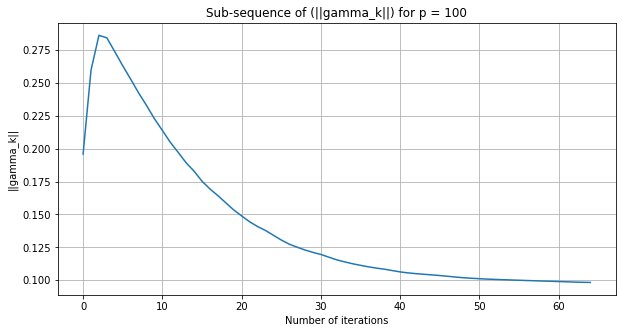

In [455]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) 
plt.plot(ind, gammas)   

plt.title(f"Sub-sequence of (||gamma_k||) for p = {n}")  
plt.xlabel("Number of iterations")    
plt.ylabel("||gamma_k||")      

plt.grid(True) 

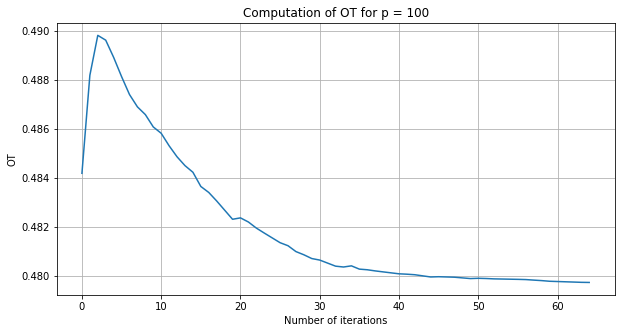

In [456]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) 
plt.plot(ind, ot)   

plt.title(f"Computation of OT for p = {n}")  
plt.xlabel("Number of iterations")    
plt.ylabel("OT")

plt.grid(True) 

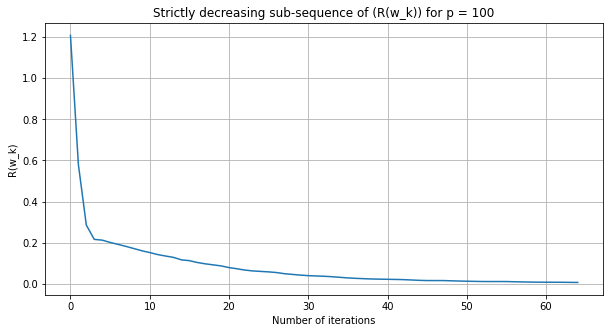

In [457]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) 
plt.plot(ind, normes[1:])   

plt.title(f"Strictly decreasing sub-sequence of (R(w_k)) for p = {n}")  
plt.xlabel("Number of iterations")    
plt.ylabel("R(w_k)")      

plt.grid(True) 
plt.show()